# TITLE

# Introduction

blah blah blah

# Methods

**Loading Libraries**

In [1]:
library(tidyverse)
library(tidymodels)
library(digest)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Uploading Data and Tidying**

In [2]:
# the data was retreived from: 
data_link <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data <- read_delim(data_link, ',', col_names = FALSE)

head(data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
# renaming the columns to their variable titles
colnames(data)[1] <- "age"
colnames(data)[2] <- "sex"
colnames(data)[3] <- "chest_pain_type"
colnames(data)[4] <- "resting_bp"
colnames(data)[5] <- "cholestrol"
colnames(data)[6] <- "fasting_blood_sugar"
colnames(data)[7] <- "rest_ecg"
colnames(data)[8] <- "max_heart_rate"
colnames(data)[9] <- "exercise_angina"
colnames(data)[14] <- "hd_diagnosis"

# selecting variables that are of interest to our investigation
data <- select(data, 
                     age,
                     sex,
                     chest_pain_type,
                     resting_bp,
                     cholestrol,
                     fasting_blood_sugar, 
                     rest_ecg,
                     max_heart_rate,
                     exercise_angina,
                     hd_diagnosis)

head(data)

age,sex,chest_pain_type,resting_bp,cholestrol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,hd_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,0
67,1,4,160,286,0,2,108,1,2
67,1,4,120,229,0,2,129,1,1
37,1,3,130,250,0,0,187,0,0
41,0,2,130,204,0,2,172,0,0
56,1,2,120,236,0,0,178,0,0


**Set Seed (will not be changed nor shown after this)**

In [4]:
set.seed(2000) ### DO NOT CHANGE!

**Split our dataset to Training and Testing data**

In [5]:
cleveland_split <- initial_split(data, prop=0.75, stata=resting_bp)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_split

<Training/Testing/Total>
<227/76/303>

In [6]:
#checking for null/na data in the training data
paste("Number of null values:", sum(map_df(cleveland_training, is.null)))
paste("Number of N/A values:", sum(map_df(cleveland_training, is.na)))

[1] "Number of null values: 0"

[1] "Number of N/A values: 0"

**Initial Assessment**

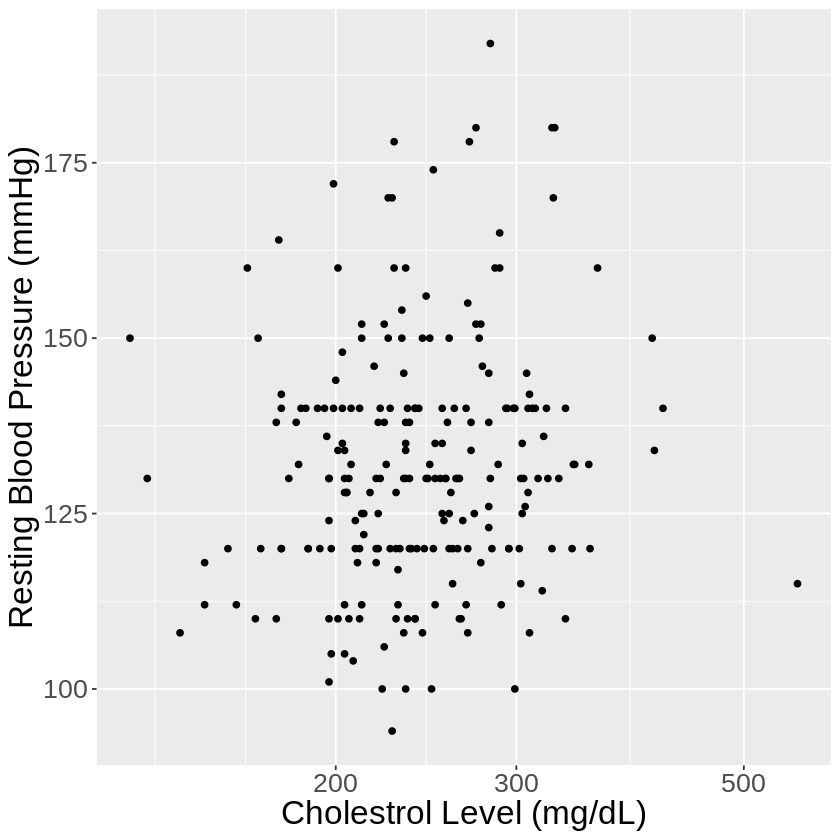

In [7]:
cleveland_plot <- cleveland_training |>
    ggplot(aes(x=cholestrol, y=resting_bp)) +
    geom_point() +
    labs(x="Cholestrol Level (mg/dL)", y="Resting Blood Pressure (mmHg)") + 
    scale_x_log10() +
    theme(text = element_text(size=20))

cleveland_plot

Initial analysis and assessment here

**Model Specification**

explanation/discussion

In [8]:
#CODE HERE

**Cross-Validation of Training Data with 5 folds**

explanation

In [9]:
#CODE HERE

**Tuning the Workflow**

explanation

In [10]:
#CODE HERE (gridvals, etc.)

**Determining the Minimum RMSPE**

explanation

In [11]:
#CODE HERE

**Evaluating on our Testing Dataset**

explanantion

In [12]:
#CODE HERE

# Results

In [13]:
#CODE HERE (plot our final graph?) 

# Discussion

explanation